# Minería de Datos: Trabajo Final:

### Importación de las librerías necesarias:

In [1]:
# Importación de bibliotecas generales
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de matplotlib para interactividad
plt.ion()  # Mantén la interactividad de matplotlib

# Importación de herramientas de preprocesamiento y transformación de sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import category_encoders as ce

# Importación de herramientas de modelado y evaluación de sklearn
from sklearn import neighbors, model_selection, metrics
from sklearn.base import BaseEstimator, TransformerMixin

# Configuración de la visualización de diagramas de sklearn
from sklearn import set_config
set_config(display="diagram")


### Lectura de datos:

Leemos los datos:

In [2]:
data_path = 'data/data.csv'
data = pd.read_csv(data_path, index_col=0)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Análisis de tipos de datos y nulos:

In [3]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
variables_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

variables_categoricas = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", 
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", 
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", 
    "Contract", "PaperlessBilling", "PaymentMethod"
]

Verificamos a ver si hay valores nulos, vacíos o espacios:

In [5]:
# Contar cuántos valores son exactamente ' ' en cada columna
conteo_espacios = (data == ' ').sum()
print("Conteo de espacios en blanco (' '):")
print(conteo_espacios)

# Verificar la cantidad de valores nulos (NaN) en cada columna
conteo_nulos = data.isnull().sum()
print("\nConteo de valores nulos:")
print(conteo_nulos)

# Contar cuántos valores son cadenas vacías ('') en cada columna
conteo_cadenas_vacias = (data == '').sum()
print("\nConteo de cadenas vacías (''):")
print(conteo_cadenas_vacias)


Conteo de espacios en blanco (' '):
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Conteo de valores nulos:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Conteo de c

Podemos comprobar como la variable TotalCharges es de tipo objeto debido a que tiene valores perdidos representados como ' '. Para solicionar esto, vamos a convertir la variable a tipo numérico.

In [6]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors='coerce')

### Análisis de los datos:

Separamos los datos en X e y:

In [7]:
variablesEntrada = data.columns[:-1]
variableSalida = data.columns[-1]

X = data.iloc[:, :-1].copy()
y = data.iloc[:,-1].copy()

Convertimos las categorías a números con codificación ordinal:

In [8]:
y[y == "No"] = 0
y[y == "Yes"] = 1
y = y.astype(int)

Analizamos la distribución de las clases de salida:

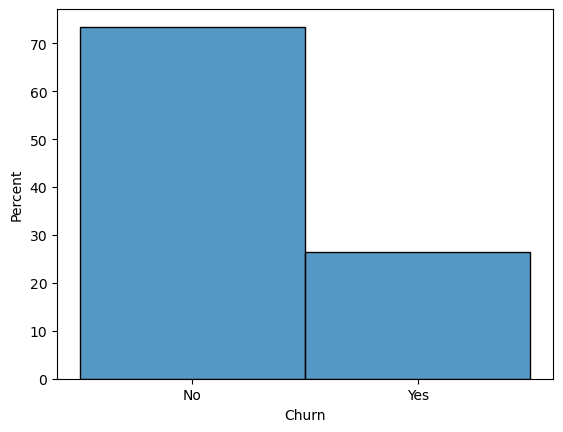

In [9]:
clase_0 = "No"
clase_1 = "Yes"

sns.histplot(data=y, bins=2, stat='percent', discrete=True)
plt.xticks([0, 1], [clase_0, clase_1])
plt.show()

Podemos observar que las clases están algo desbalanceadas, pero puede tratarse debido a que las reseñas neutrales y no satisfechas están agrupadas.

Visualizamos la distribución de las variables numéricas:

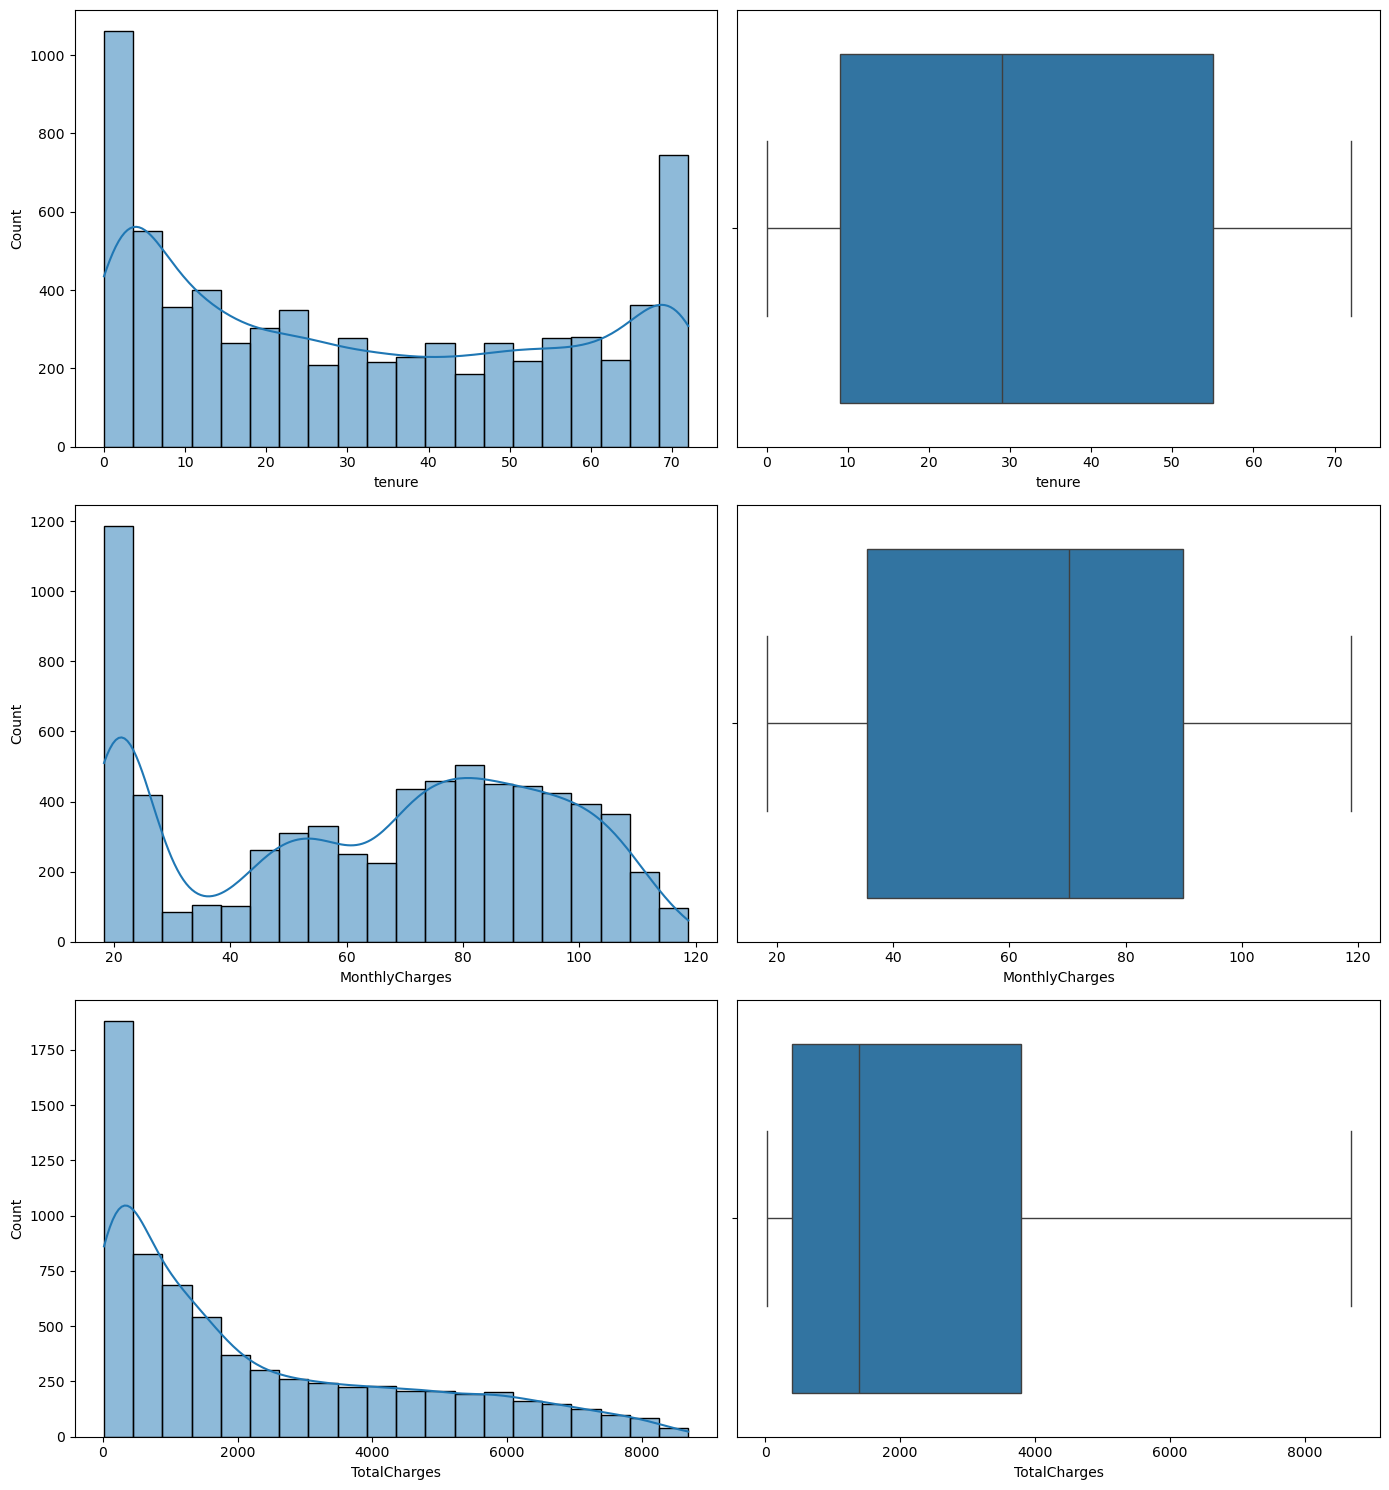

In [10]:
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=2, figsize=(14, 15))

for i in range(len(variables_numericas)):
    sns.histplot(data=X, x=variables_numericas[i], ax=axes[i, 0], bins=20, kde=True)
    sns.boxplot(data=X, x=variables_numericas[i], ax=axes[i, 1])

fig.tight_layout()

Visualizamos la distribución de las variables categóricas:

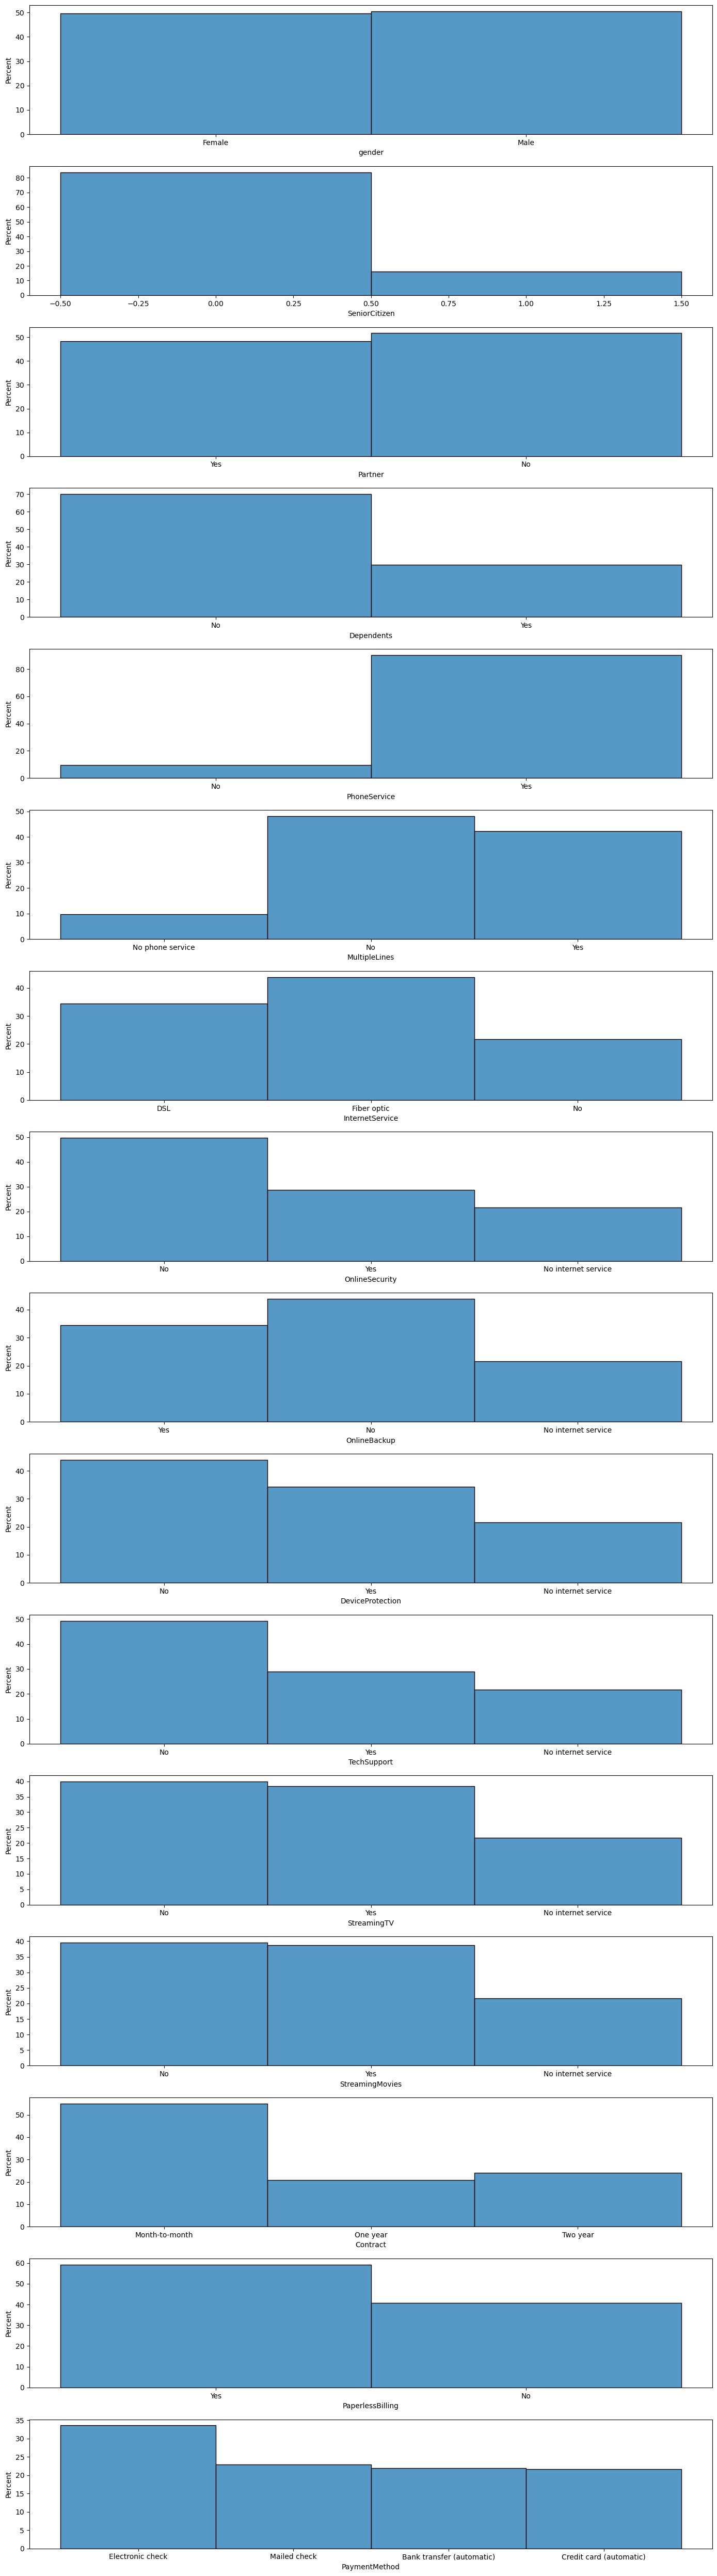

In [11]:
fig, axes = plt.subplots(nrows=len(variables_categoricas), ncols=1, figsize=(14, 50))

for i in range(len(variables_categoricas)):
    sns.histplot(data=X, x=variables_categoricas[i], stat='percent', discrete=True, ax=axes[i])

fig.tight_layout()

Visualizamos la relación entre las variables numéricas y la salida:

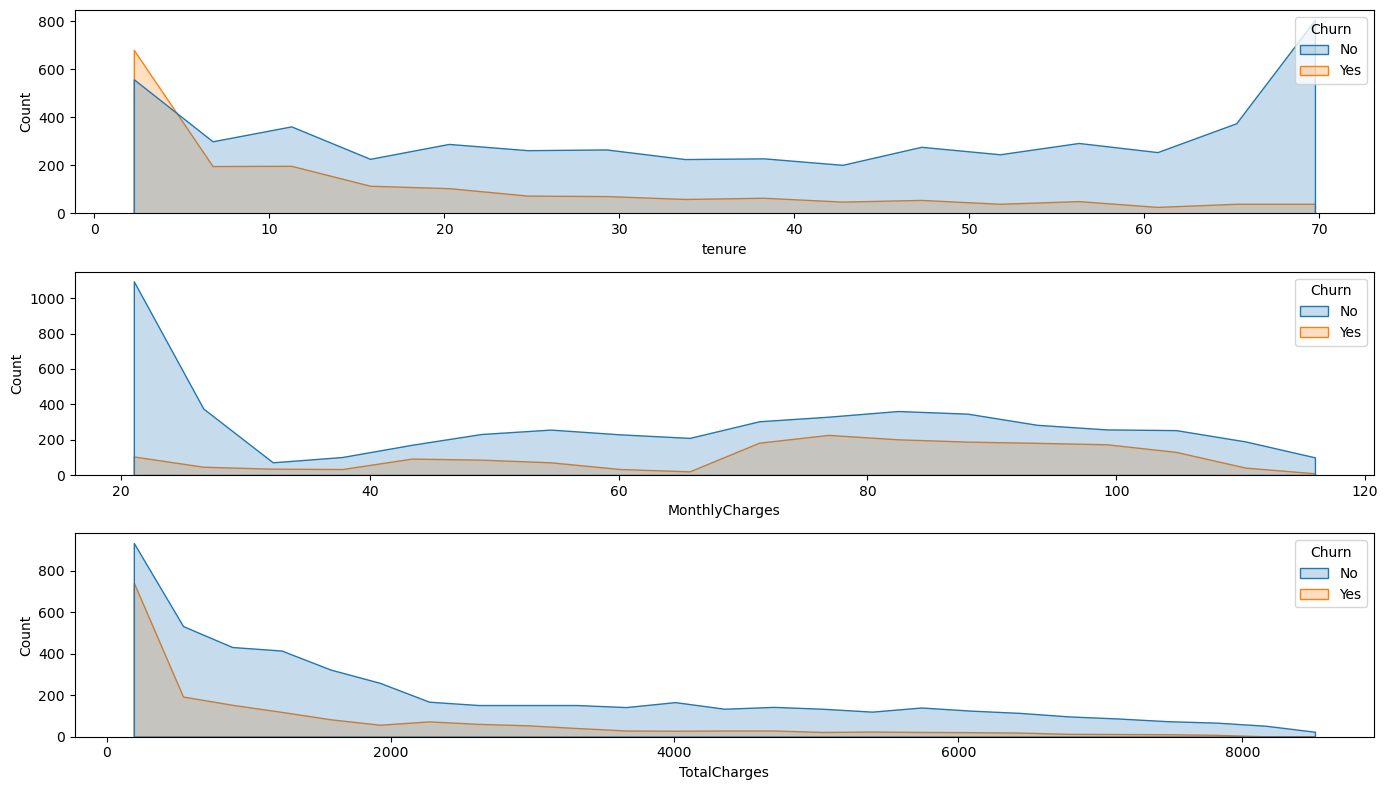

In [12]:
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=1, figsize=(14, 8))

for i in range(len(variables_numericas)):
    sns.histplot(data=data, x=variables_numericas[i], hue=variableSalida, ax=axes[i], element='poly')

plt.tight_layout()
plt.show()

Visualizamos la relación entre las variables categóricas y la salida:

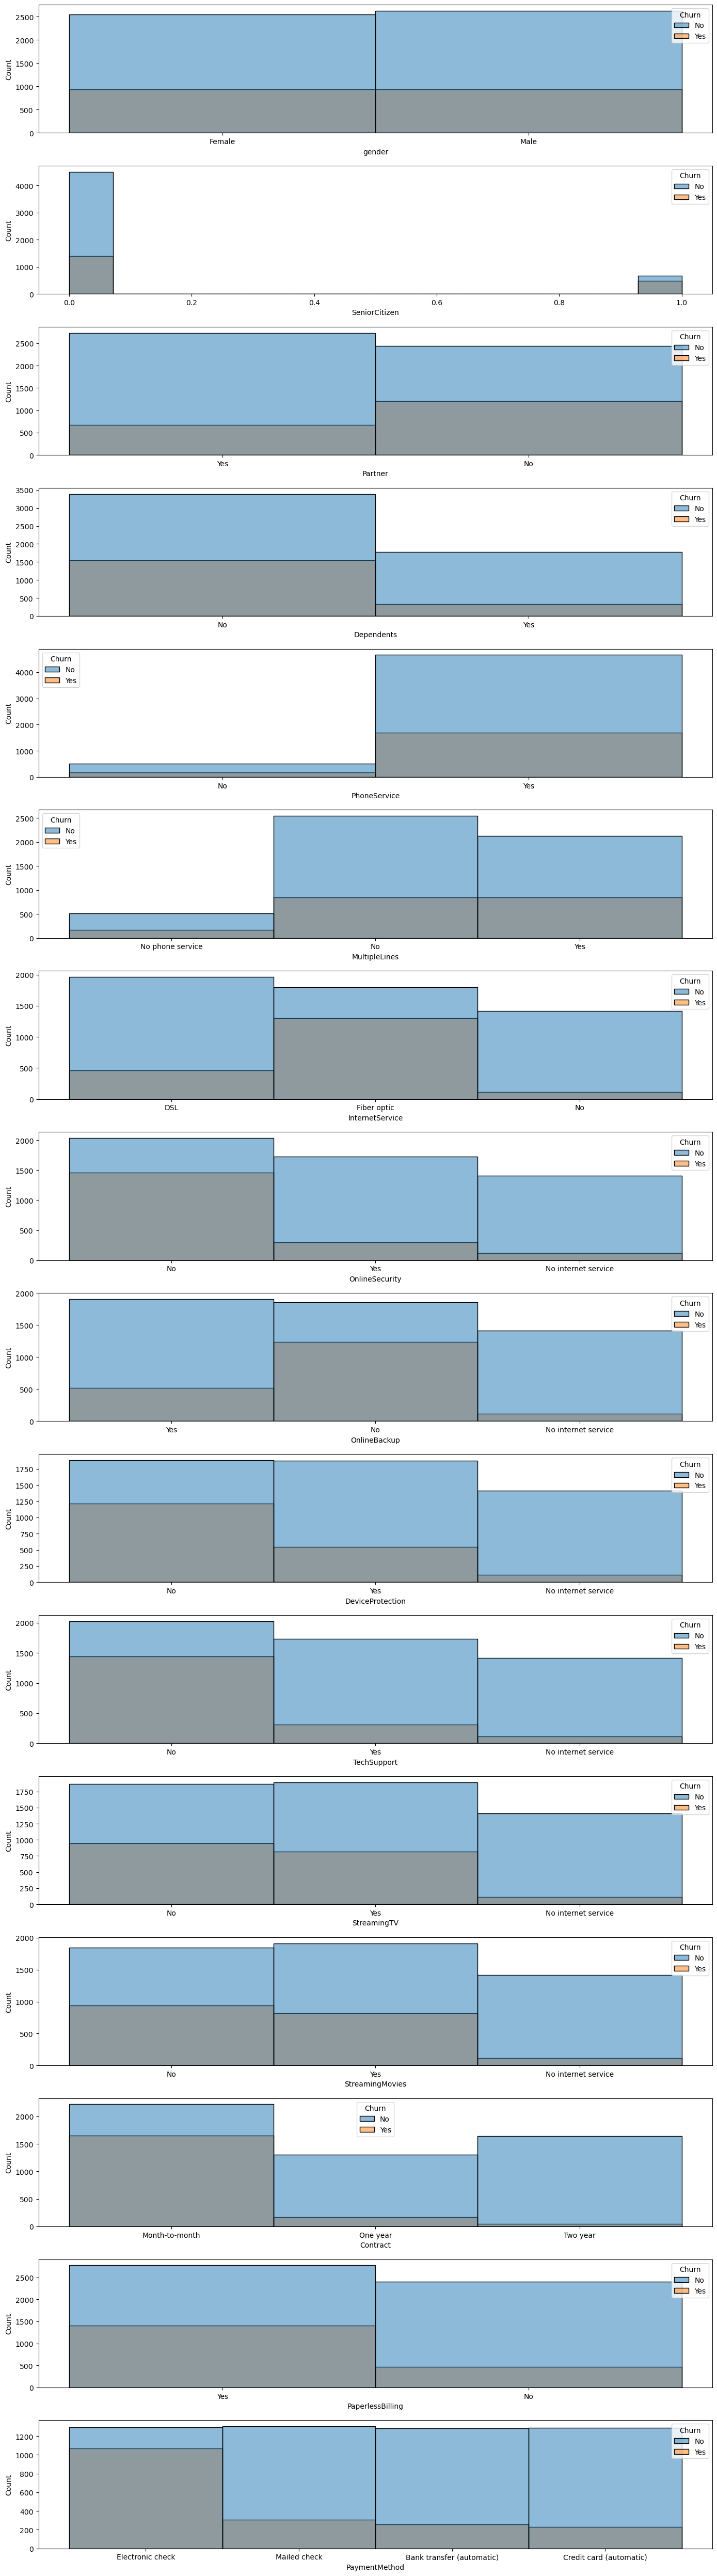

In [13]:
fig, axes = plt.subplots(nrows=len(variables_categoricas), ncols=1, figsize=(14, 50))

for i in range(len(variables_categoricas)):
    sns.histplot(data=data, x=variables_categoricas[i], hue=variableSalida, ax=axes[i])

plt.tight_layout()
plt.show()

Visualizamos las relaciones entre las variables numéricas:

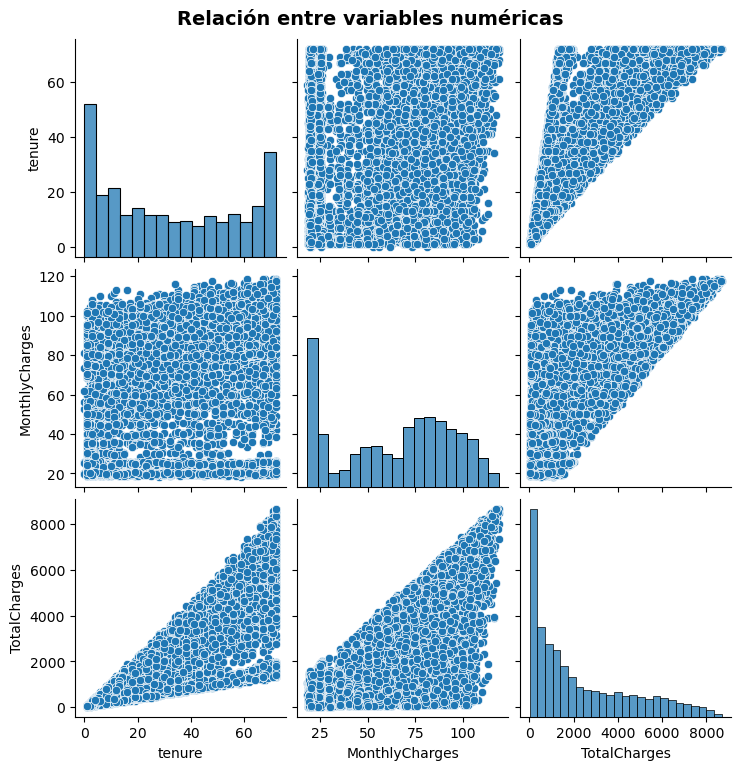

In [14]:
sns.pairplot(data=X[variables_numericas], kind='scatter', diag_kind='hist', height=2.5)
plt.suptitle('Relación entre variables numéricas', y=1.02, fontsize=14, fontweight="bold")
plt.show()

### Detección de outliers:

Para evitar outliers, éstos serán detectados con el método del rango intercuartil, y sustituidos por la media.

In [15]:
class DetectorOutliers(BaseEstimator, TransformerMixin):
    def _init_(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_outliers = X.copy()
        for col in X.columns:
            if col in variables_numericas:
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                limite_inferior = Q1 - 1.5 * IQR
                limite_superior = Q3 + 1.5 * IQR
                X_outliers[col] = X[col].apply(lambda x: np.nan if x < limite_inferior or x > limite_superior else x)
        return X_outliers

outilers_preprocessor = Pipeline(steps=[
    ('detector_outliers', DetectorOutliers()),  
    ('imputador', SimpleImputer(strategy='mean'))
])


### Tratamiento de los valores nulos:

Como se ha mencionado anteriormente, hemos encontrado valores nulos en la variable "TotalCharges". Por ello, hemos decidido sustituir estos valores por la media.

### Transformación de variables: categórica a numérica:

En nuestro problema tenemos algunas variables categóricas. Estas deben ser convertidas a numéricas, ya que más adelante, cuando necesitemos aplicar un modelo de aprendizaje automático éstas nos darán problemas. Como primera prueba, comenzaremos utilizando la codificación binaria.

Las variables categóricas disponibles son las siguientes:

- gender
- SeniorCitizen
- Partner
- Dependents
- PhoneService
- MultipleLines
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- Contract
- PaperlessBilling
- PaymentMethod

Sin embargo, no necesitamos codificar todas, ya que SeniorCitizen ya viene codificada en binario.


### Normalización de los datos:

Para que no haya variables con más importancia que otras, es muy importante normalizar los datos. Dependiendo de la distribución de las variables, aplicaremos una normalización Z-score o basada en el máximo y el mínimo (min-max):

__Normalización Z-score:__

- tenure 
- MonthlyCharges
- TotalCharges

__Normalización min-max:__

- gender
- SeniorCitizen
- Partner
- Dependents
- PhoneService
- MultipleLines
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- Contract
- PaperlessBilling
- PaymentMethod


En el caso de la normalización min-max, el nuevo rango de las variables será [-1, 1], para que tenga un rango similiar a los datos normalizados con Z-score.

### Pipelines de preprocesamiento:

Para aplicar el preprocesamiento de manera más sencilla y evitar errores que nos lleven a cometer Data Leakage, crearemos una Pipeline que se encargue de aplicar este preprocesamiento de manera adecuada.

Primero creamos la Pipeline que preprocesará las variables categóricas aún NO codificadas:

In [16]:
categorical_preprocessor = Pipeline(steps=[
    ('binary_encoder', ce.BinaryEncoder()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

Crearemos otra Pipeline que se encargue de preprocesar las variables con valores faltantes:

In [17]:
nan_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

Creamos un ColumnTransformer que se encargue de transformar todas las variables:

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        # Codificamos y normalizamos las variables categóricas NO codificadas
        ('categorical_preprocessor', categorical_preprocessor, [
            "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService",
            "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
            "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
            "Contract", "PaperlessBilling", "PaymentMethod"
        ]),
        # Imputamos y normalizamos en las variables con valores faltantes
        ('nan_preprocessor', nan_preprocessor, [
            "TotalCharges"
        ]),
        # Normalizamos las variables numéricas sin valores faltantes con Z-score
        ('z_score_scaler', StandardScaler(), [
            "tenure", "MonthlyCharges"
        ])
    ]
)

In [19]:
X_modified = preprocessor.fit_transform(X)

# Visualizamos los datos transformados
pd.DataFrame(X_modified).head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,...,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-0.994971,-1.277445,-1.160323
1,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-0.173876,0.066327,-0.259629
2,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-0.960399,-1.236724,-0.362660
3,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-0.195400,0.514251,-0.746535
4,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-0.941193,-1.236724,0.197365


### Pipeline con preprocesamiento y KNN:

Dividimos los datos en train, validación y test:

In [20]:
X_resto, X_test, y_resto, y_test = model_selection.train_test_split(X, y, test_size=0.1, stratify=y, random_state=1234)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_resto, y_resto, train_size=0.8, stratify=y_resto, random_state=1234)

Definimos una función que se encarga de realizar una búsqueda en cuadrícula de los hiperparámetros establecidos para el modelo proporcionado. Esta función evalúa cada combinación de hiperparámetros mediante validación cruzada, mostrando los resultados de todas las combinaciones y devolviendo el modelo con el mejor puntaje obtenido.

La función utiliza `GridSearchCV` de `sklearn` para probar diferentes configuraciones y seleccionar la que maximice la puntuación según el evaluador (`scorer`) proporcionado. Además, imprime los resultados de todas las combinaciones de parámetros y devuelve el mejor modelo, su puntaje y los parámetros asociados.

#### Parámetros de entrada:
- `estimator`: El modelo a ajustar (por ejemplo, un clasificador como `KNeighborsClassifier`).
- `param_grid`: Un diccionario con los hiperparámetros a probar.
- `scorer`: Un objeto de puntuación (por ejemplo, AUC, precisión, etc.).
- `X`: Los datos de entrada (características).
- `y`: Las etiquetas de las clases.

#### Valor de salida:
- Devuelve el mejor estimador ajustado (`best_estimator_`), la mejor puntuación (`best_score_`), y los mejores parámetros (`best_params_`).


In [21]:
def tunearClasificador(estimator, param_grid, scorer, X, y):
    np.random.seed(12)
    grid = model_selection.GridSearchCV(estimator, param_grid, scoring=scorer, cv=5, verbose=3)
    grid.fit(X, y)

    # Mostrar los resultados de todas las combinaciones de los hiperparámetros
    print("Resultados de la búsqueda en cuadrícula:")
    for mean_score, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
        print(f"Puntuación: {mean_score:.4f} para los parámetros: {params}")

    return grid.best_estimator_, grid.best_score_, grid.best_params_

Creamos un objeto make_scorer con la métrica del AUC de la curva PR:

In [22]:
score_auc = metrics.make_scorer(score_func=metrics.roc_auc_score,
                                greater_is_better=True,
                                response_method=['predict_proba', 'decision_function', 'predict'])

Definimos los parámetros que queramos probar, creamos el modelo con el preprocesador y KNN, y por último obtenemos el mejor clasificador en base a la curva ROC:

In [23]:
param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

modelo = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', neighbors.KNeighborsClassifier())
])

bestKNN, best_val, best_hipPar =  tunearClasificador(modelo, param_grid, score_auc, X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=0.652 total time=   0.2s
[CV 2/5] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=0.659 total time=   0.1s
[CV 3/5] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=0.616 total time=   0.1s
[CV 4/5] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=0.645 total time=   0.1s
[CV 5/5] END knn__n_neighbors=1, knn__p=1, knn__weights=uniform;, score=0.634 total time=   0.1s
[CV 1/5] END knn__n_neighbors=1, knn__p=1, knn__weights=distance;, score=0.652 total time=   0.1s
[CV 2/5] END knn__n_neighbors=1, knn__p=1, knn__weights=distance;, score=0.659 total time=   0.1s
[CV 3/5] END knn__n_neighbors=1, knn__p=1, knn__weights=distance;, score=0.616 total time=   0.1s
[CV 4/5] END knn__n_neighbors=1, knn__p=1, knn__weights=distance;, score=0.645 total time=   0.1s
[CV 5/5] END knn__n_neighbors=1, knn__p=1, knn__weights=dista

In [24]:
# Importamos el método set_config
from sklearn import set_config

# Configuramos para que el resultado se muestre gráficamente
set_config(display="diagram")

print(f"Puntuación para el mejor clasificador: {best_val:.4f} para los parámetros: {best_hipPar}")
# Muestra el diagrama del Pipeline
bestKNN


Puntuación para el mejor clasificador: 0.8225 para los parámetros: {'knn__n_neighbors': 13, 'knn__p': 1, 'knn__weights': 'uniform'}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_preprocessor',
                                                  Pipeline(steps=[('binary_encoder',
                                                                   BinaryEncoder()),
                                                                  ('scaler',
                                                                   MinMaxScaler(feature_range=(-1,
                                                                                               1)))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('nan_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges']),
                                                 ('z_score_scaler',
                                                  StandardScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])])),
                ('knn', KNeighborsClassifier(n_neighbors=13, p=1))])